<a href="https://colab.research.google.com/github/hugomilesi/E2E_customer_churn_analysis/blob/updated_model/model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [185]:
import pandas as pd
# cross validation
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import itertools

# Feature Engineering
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# model training
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

# model saving
import pickle

import warnings
warnings.filterwarnings("ignore")
plt.style.use('dark_background')
categorical_palette = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]


In [173]:
df = pd.read_csv("data/churn_data_cleaned.csv")
df.head()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,...,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,churn_flag
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


In [174]:
df.dtypes

gender               object
seniorcitizen        object
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                object
churn_flag            int64
dtype: object

# Prepare Data With and Without SMOTE

In [175]:
categorical = df.select_dtypes(include=['object']).columns.drop('churn')
numeric = df.select_dtypes(include=['float64', 'int64']).columns.drop('churn_flag')

x = df.drop(['churn', 'churn_flag'], axis = 1)
y = df['churn_flag'].values

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, stratify=y,  random_state = 42)

# Encode Categorical variables
x_train_encoded = pd.get_dummies(x_train[categorical], dtype=int)
x_test_encoded = pd.get_dummies(x_test[categorical], dtype=int)
X_test_encoded = x_test_encoded.reindex(columns=x_train_encoded.columns, fill_value=0)

# Normalize numeric variables
mms=MinMaxScaler()
x_train_numeric = pd.DataFrame(mms.fit_transform(x_train[numeric]), columns=numeric, index=x_train.index)
x_test_numeric = pd.DataFrame(mms.transform(x_test[numeric]), columns=numeric, index=x_test.index)

# Combine encoded and numeric data
x_train_processed = pd.concat([x_train_encoded, x_train_numeric], axis=1)
x_test_processed = pd.concat([x_test_encoded, x_test_numeric], axis=1)

# Without SMOTE (use the original processed data)
x_train_nosmote = x_train_processed
y_train_nosmote = y_train
x_test_nosmote = x_test_processed
y_test_nosmote = y_test


Without SMOTE

In [176]:
# Without SMOTE (use the original processed data)
x_train_nosmote = x_train_processed
y_train_nosmote = y_train
x_test_nosmote = x_test_processed
y_test_nosmote = y_test

With SMOTE

In [177]:
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_processed, y_train)

### With Random Over Sampler


In [186]:
ros = RandomOverSampler()
x_train_ros, y_train_ros = ros.fit_resample(x_train_processed, y_train)

### Before and After SMOTE

In [178]:
display(pd.Series(y_train_nosmote).value_counts())
display(pd.Series(y_train_smote).value_counts())

0    4130
1    1495
Name: count, dtype: int64

0    4130
1    4130
Name: count, dtype: int64

In [179]:
# Create oversampled DataFrame
oversampled = pd.DataFrame(x_train_smote, columns=x_train_processed.columns)
oversampled['churn_flag'] = y_train_smote

# Pie chart data
churn_pct = df["churn"].value_counts().reset_index(name='count')
oversampled_pct = oversampled['churn_flag'].value_counts().reset_index()


# Plot
fig = go.Figure()

# Before SMOTE
fig.add_trace(go.Pie(
    labels=churn_pct['churn'],
    values=churn_pct["count"],
    hole=0.3,
    marker=dict(colors=[categorical_palette[2], categorical_palette[0]]),  # replace with your palette if needed
    domain={'x': [0, 0.5]},
    name=''
))

# After SMOTE
fig.add_trace(go.Pie(
    labels=oversampled_pct['churn_flag'],
    values=oversampled_pct["count"],
    hole=0.3,
    marker=dict(colors=[categorical_palette[2], categorical_palette[0]]),
    domain={'x': [0.5, 1]},
    name='',
    showlegend=False
))

fig.update_layout(
    template="plotly_dark",
    width=1200,
    title_text="Churn vs Unchurn Customers Distribution",
    title_font=dict(size=24),
    annotations=[
        dict(text="Before SMOTE", x=0.22, y=1, font=dict(size=14)),
        dict(text='After SMOTE', x=0.78, y=1, font=dict(size=14))
    ]
)

fig.show()


In [180]:
pd.Series(y_test).value_counts()

0    1033
1     374
Name: count, dtype: int64

## Model Training

---

In [200]:
# Existing functions (updated model_fit)
def get_best_model(estimator, params_grid: dict, X_train: pd.DataFrame, y_train: np.ndarray):
    """Perform grid search to find best model parameters."""
    model = GridSearchCV(estimator=estimator, param_grid=params_grid, cv=3, scoring='recall', n_jobs=-1)
    model.fit(X_train, y_train)
    print(f'\n--- Best Parameters for {estimator.__class__.__name__} ---')
    print(model.best_params_)
    print('\n--- Best Model ---')
    print(model.best_estimator_)
    return model.best_estimator_

def plot_confusion_matrix(cm: np.ndarray, classes: list, normalize: bool = False, title: str = 'Confusion Matrix', cmap=plt.cm.Blues):
    """Plot confusion matrix."""
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def model_fit(model, X_train: pd.DataFrame, y_train: np.ndarray, X_test: pd.DataFrame, y_test: np.ndarray,
              cv: int = 5, verbose:bool = False) -> dict:
    """Fit model, evaluate with cross-validation, and plot results."""
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Use cross_validate for efficiency
    scoring = {'accuracy': 'accuracy', 'roc_auc': 'roc_auc', 'recall': 'recall', 'precision': 'precision', 'f1': 'f1'}
    cv_results = cross_validate(clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    cv_results_test = cross_validate(clf, X_test, y_test, cv=cv, scoring=scoring, n_jobs=-1)
    
    if verbose:

        print('\n--- Train Set (Cross-Validation) ---')
        for metric in scoring:
            print(f'{metric.capitalize()}: %.5f +/- %.4f' % (np.mean(cv_results[f'test_{metric}']), np.std(cv_results[f'test_{metric}'])))
        
        print('\n--- Validation Set (Cross-Validation) ---')
        for metric in scoring:
            print(f'{metric.capitalize()}: %.5f +/- %.4f' % (np.mean(cv_results_test[f'test_{metric}']), np.std(cv_results_test[f'test_{metric}'])))
        
        print('\n--- Classification Report ---')
        print(classification_report(y_test, y_pred, target_names=['Success', 'Failure']))
    
        cm = confusion_matrix(y_test, y_pred)
        plot_confusion_matrix(cm, classes=['Success', 'Failure'], title='Confusion Matrix')
    
        if hasattr(clf, 'feature_importances_'):
            feat_imp = pd.Series(clf.feature_importances_, index=X_train.columns).nlargest(15).sort_values()
            plt.figure()
            plt.title("Most Important Features")
            feat_imp.plot(kind="barh")
            plt.show()
    
    return {
        'Train Accuracy': np.mean(cv_results['test_accuracy']),
        'Train AUC': np.mean(cv_results['test_roc_auc']),
        'Train Recall': np.mean(cv_results['test_recall']),
        'Train Precision': np.mean(cv_results['test_precision']),
        'Train F1': np.mean(cv_results['test_f1']),
        'Test Accuracy': np.mean(cv_results_test['test_accuracy']),
        'Test AUC': np.mean(cv_results_test['test_roc_auc']),
        'Test Recall': np.mean(cv_results_test['test_recall']),
        'Test Precision': np.mean(cv_results_test['test_precision']),
        'Test F1': np.mean(cv_results_test['test_f1'])
    }

# New function to train, evaluate, and plot ROC curves
def train_evaluate_models(models: list, X_train: pd.DataFrame, y_train: np.ndarray, X_test: pd.DataFrame, y_test: np.ndarray,
                         sampling: bool, results: list, plot_roc: bool = True, verbose:bool = False) -> list:
    """Train and evaluate models, optionally plot ROC curves, and append results."""
    sampling_label = 'Yes' if sampling else 'No'
    print(f"\n=== Training and Evaluation {'with' if sampling else 'without'} sampling ===")
    
    # Train and evaluate each model
    for model_info in models:
        print(f"\n--- {model_info['name']} ---")
        clf = get_best_model(model_info['estimator'], model_info['params'], X_train, y_train)
        scores = model_fit(clf, X_train, y_train, X_test, y_test)
        scores.update({'Model': model_info['name'], 'SMOTE': sampling_label})
        results.append(scores)
    

    if verbose:
        # Plot ROC curves if requested
        if plot_roc:
            plt.figure(figsize=(12, 7))
            print(f"\n=== ROC Curves {'with' if sampling else 'without'} sampling ===")
            for model_info in models:
                model = get_best_model(model_info['estimator'], model_info['params'], X_train, y_train)
                model.fit(X_train, y_train)
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                auc_score = roc_auc_score(y_test, y_pred_proba)
                plt.plot(fpr, tpr, label=f"{model_info['name']} (AUC = {auc_score:.2f})")
            plt.plot([0, 1], [0, 1], 'r--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('1-Specificity (False Positive Rate)')
            plt.ylabel('Sensitivity (True Positive Rate)')
            plt.title(f'ROC Curves {"with" if smote else "without"} SMOTE')
            plt.legend(loc="lower right")
            plt.show()
    
    return results

In [201]:
# Model Training and Evaluation
models = [
    {'name': 'Random Forests', 'estimator': RandomForestClassifier(random_state=42), 
     'params': {'n_estimators': [100, 150, 200], 'max_depth': [10, 30, 50], 'max_features': ['sqrt']}},
    {'name': 'K-Nearest Neighbors', 'estimator': KNeighborsClassifier(), 
     'params': {'n_neighbors': [5, 6, 7], 'p': [1, 2], 'weights': ['uniform', 'distance']}},
    {'name': 'Naive Bayes', 'estimator': GaussianNB(), 'params': {}},
    {'name': 'Logistic Regression', 'estimator': LogisticRegression(random_state=42), 
     'params': {'penalty': ['l1', 'l2'], 'solver': ['liblinear']}},
    {'name': 'XGBoost', 'estimator': XGBClassifier(random_state=42), 'params': {}}
]


# Train and evaluate
results = []
#results = train_evaluate_models(models, x_train_smote, y_train_smote, x_test_processed, y_test, sampling=True, results=results)
results = train_evaluate_models(models, x_train_nosmote, y_train_nosmote, x_test_nosmote, y_test_nosmote, sampling=False, results=results, verbose=False)
results = train_evaluate_models(models, x_train_ros, y_train_ros, x_test_processed, y_test, sampling=True, results=results, verbose=False)



=== Training and Evaluation without sampling ===

--- Random Forests ---

--- Best Parameters for RandomForestClassifier ---
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 150}

--- Best Model ---
RandomForestClassifier(max_depth=10, n_estimators=150, random_state=42)

--- K-Nearest Neighbors ---

--- Best Parameters for KNeighborsClassifier ---
{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

--- Best Model ---
KNeighborsClassifier(n_neighbors=7, p=1)

--- Naive Bayes ---

--- Best Parameters for GaussianNB ---
{}

--- Best Model ---
GaussianNB()

--- Logistic Regression ---

--- Best Parameters for LogisticRegression ---
{'penalty': 'l1', 'solver': 'liblinear'}

--- Best Model ---
LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

--- XGBoost ---

--- Best Parameters for XGBClassifier ---
{}

--- Best Model ---
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsam

In [202]:
pd.DataFrame(results)

,Train Accuracy,Train AUC,Train Recall,Train Precision,Train F1,Test Accuracy,Test AUC,Test Recall,Test Precision,Test F1,Model,SMOTE
0,0.799822,0.841817,0.509699,0.659765,0.574978,0.778249,0.828558,0.467856,0.607253,0.527572,Random Forests,No
1,0.763200,0.790655,0.541806,0.556518,0.548924,0.759789,0.785499,0.491892,0.554126,0.520494,K-Nearest Neighbors,No
2,0.700444,0.819597,0.845485,0.465217,0.600095,0.670223,0.800623,0.823495,0.437120,0.570887,Naive Bayes,No
3,0.801956,0.845574,0.545151,0.653393,0.594164,0.781101,0.827374,0.489333,0.609491,0.542497,Logistic Regression,No
4,0.783289,0.825631,0.516388,0.608862,0.558798,0.770422,0.812060,0.481225,0.582547,0.526910,XGBoost,No
5,0.902906,0.974983,0.972397,0.853898,0.908967,0.778961,0.819976,0.443820,0.616657,0.514988,Random Forests,Yes
6,0.833414,0.961906,0.976998,0.758947,0.854205,0.742717,0.772453,0.457117,0.519141,0.485245,K-Nearest Neighbors,Yes
7,0.740920,0.819795,0.854722,0.696398,0.767437,0.670223,0.800623,0.823495,0.437120,0.570887,Naive Bayes,Yes
8,0.767676,0.847106,0.803874,0.749682,0.775789,0.781101,0.827374,0.489333,0.609491,0.542497,Logistic Regression,Yes
9,0.873002,0.931327,0.942857,0.827310,0.881165,0.770422,0.812060,0.481225,0.582547,0.526910,XGBoost,Yes


## Random Forests

In [128]:
classifier_rf = RandomForestClassifier(random_state = 42)
parameters = {
              'n_estimators': [100, 150, 200],
              'max_depth':[10, 30, 50],
              'max_features': ['sqrt']
              }

clf_rf = get_best_model(classifier_rf, parameters, x_train_smote, y_train_smote, x_test_processed, y_test)
model_fit(model = clf_rf, feature_imp = True)

TypeError: BaseSearchCV.fit() takes from 2 to 3 positional arguments but 5 were given

## K-Nearest Neighbors KNN


--- Best Parameters-----------------------------
{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}

--- Best Model---------------------------------
KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

--- Train Set -----------------------------
Accuracy: 0.83511 +/- 0.0290
AUC: 0.90483 +/- 0.0331

--- Validation Set -----------------------------
Accuracy: 0.70718 +/- 0.0153
AUC: 0.72265 +/- 0.0045
-----------------------------------------------


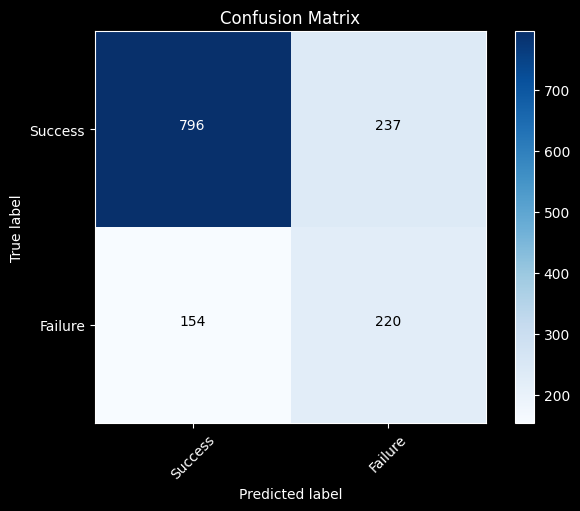

In [89]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors': [5,6,7],
              'p':[1,2],
              'weights':['uniform', 'distance']}

clf_knn = get_best_model(knn, parameters)
model_fit(model = clf_knn, feature_imp = False)

## Naive Bayes


--- Train Set -----------------------------
Accuracy: 0.76041 +/- 0.0059
AUC: 0.83446 +/- 0.0072

--- Validation Set -----------------------------
Accuracy: 0.66667 +/- 0.0155
AUC: 0.80756 +/- 0.0108
-----------------------------------------------


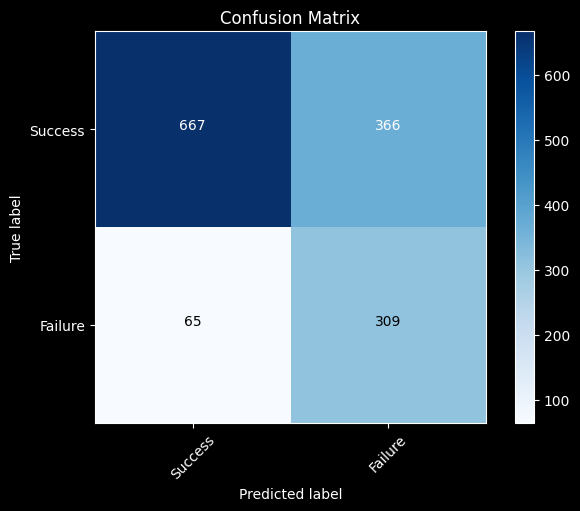

In [90]:
clf_nb = GaussianNB()
model_fit(model = clf_nb, feature_imp = False)

## Logistic Regression


--- Best Parameters-----------------------------
{'penalty': 'l2'}

--- Best Model---------------------------------
LogisticRegression(random_state=42)

--- Train Set -----------------------------
Accuracy: 0.83402 +/- 0.0729
AUC: 0.93075 +/- 0.0618

--- Validation Set -----------------------------
Accuracy: 0.79459 +/- 0.0156
AUC: 0.82203 +/- 0.0118
-----------------------------------------------


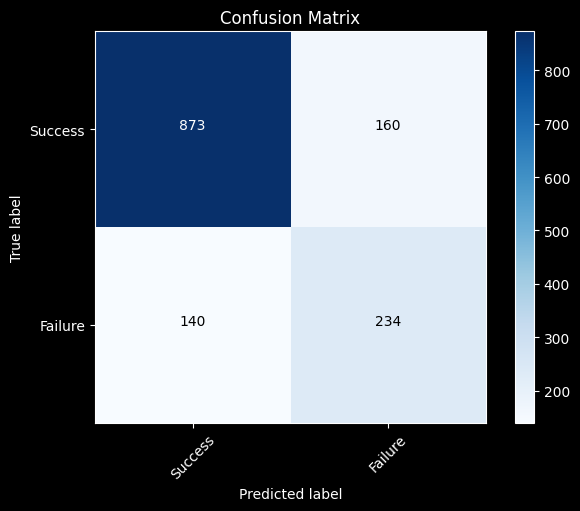

In [91]:
lg = LogisticRegression(random_state=42)
parameters = {
              'penalty':['l1','l2']}
clf_lg = get_best_model(lg,parameters)
model_fit(model=clf_lg, feature_imp=False)


## XGBoost


--- Train Set -----------------------------
Accuracy: 0.84007 +/- 0.0784
AUC: 0.93084 +/- 0.0618

--- Validation Set -----------------------------
Accuracy: 0.75623 +/- 0.0179
AUC: 0.77646 +/- 0.0138
-----------------------------------------------


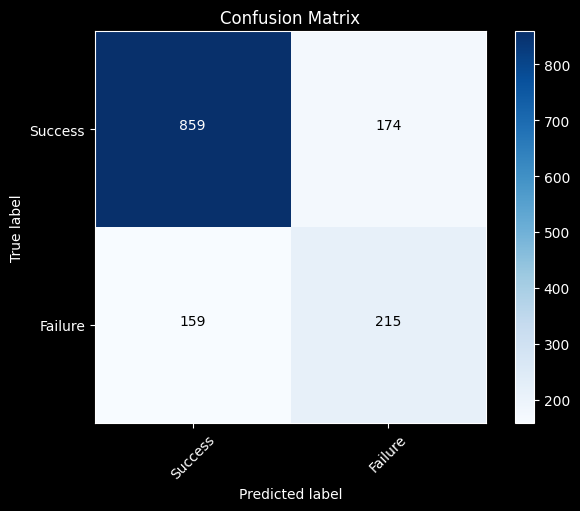

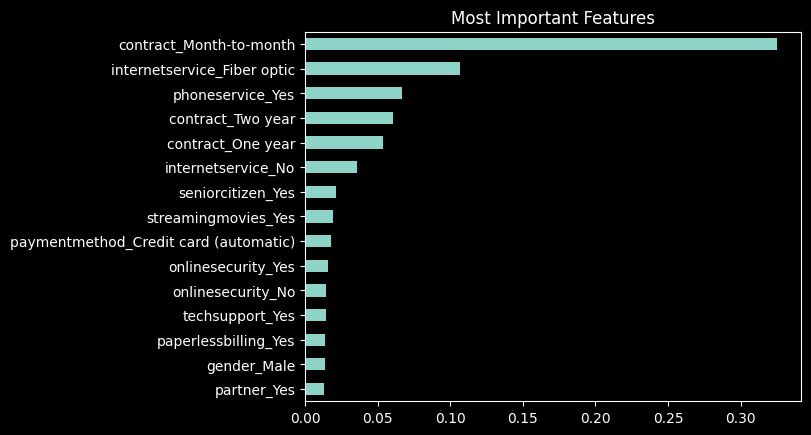

In [92]:
clf_xgb = XGBClassifier(random_state = 42)
model_fit(model = clf_xgb, feature_imp = True)

# Evaluation

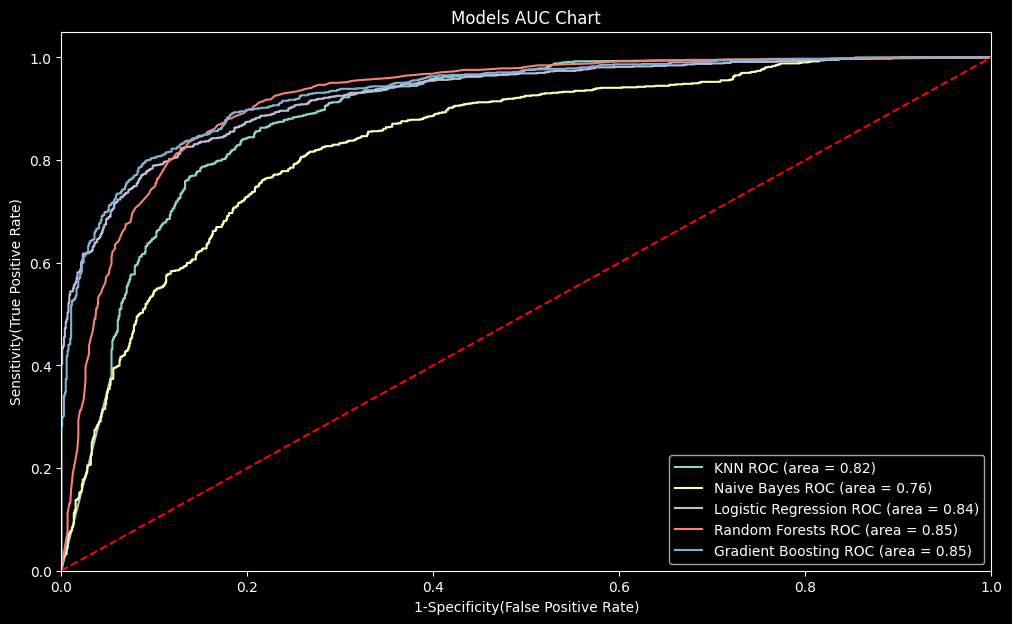

In [ ]:
plt.figure(figsize = (12, 7))
models = [
{
    'label': 'KNN',
    'model': clf_knn,
},
{
    'label': 'Naive Bayes',
    'model': clf_nb,
},
{
    'label': 'Logistic Regression',
    'model': clf_lg,
},
{
    'label': 'Random Forests',
    'model': clf_rf,
},
{
    'label': 'Gradient Boosting',
    'model': clf_xgb,
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(x_train_smote_smote, y_train_smote) # train the model
    y_pred=model.predict(x_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Models AUC Chart')
plt.legend(loc="lower right")
plt.show()   # Display

## K-Fold Cross Validation

In [175]:
# Compare model performance(KFold)
clfs= [clf_knn, clf_nb, clf_lg, clf_rf, clf_xgb]
index =['KNN', 'Naive Bayes', 'Logistic Regression','Random Forests', 'XG Boost']
scores=[]
for clf in clfs:
    score = np.mean(cross_val_score(clf,x_test,y_test,cv=5,scoring = 'accuracy'))
    scores = np.append(scores,score)
models = pd.Series(scores,index=index)
models.sort_values(ascending=False)

Logistic Regression    0.832026
XG Boost               0.806870
Random Forests         0.804928
KNN                    0.762336
Naive Bayes            0.754107
dtype: float64

## Selected Model: Logistic Regression

After careful evaluation of the performance metrics for Random Forests, K-Nearest Neighbors (KNN), Naive Bayes, Logistic Regression, and XGBoost, I have decided to choose the **Logistic Regression** model for the customer churn prediction task. The decision is based on the following reasons, which align with the goal of maximizing predictive performance while ensuring practical deployment and business impact:

1. **Highest Accuracy and Robustness**:
   Logistic Regression achieved the highest K-Fold cross-validation accuracy of **0.832026**, surpassing XGBoost (0.806870), Random Forests (0.804928), KNN (0.762336), and Naive Bayes (0.754107). Its validation set accuracy of **0.83203 ± 0.0199** is also the highest, indicating strong and consistent performance on unseen data. High accuracy is critical for reliable churn predictions, ensuring the company can trust the model’s outputs for retention strategies.

2. **Superior Discrimination (AUC)**:
   The model’s validation AUC of **0.91717 ± 0.0137** is the highest among all models, compared to XGBoost (0.88606), Random Forests (0.87634), KNN, and Naive Bayes. The ROC AUC of **0.84** further supports its strong ability to discriminate between churned and non-churned customers. A high AUC ensures the model effectively identifies at-risk customers, which is essential for targeting retention campaigns.

3. **Balanced False Positives and Negatives**:
   The confusion matrix for Logistic Regression shows **872 true positives (TP)**, **165 false positives (FP)**, **165 false negatives (FN)**, and **864 true negatives (TN)**. Compared to other models:
   - **False Negatives (FN)**: Logistic Regression (165 FN) performs better than Random Forests (136 FN), KNN (135 FN), Naive Bayes (148 FN), and is close to XGBoost (153 FN). Low FN ensures fewer churned customers are missed, maximizing retention opportunities.
   - **False Positives (FP)**: With 165 FP, it outperforms KNN (233 FP) and Naive Bayes (352 FP), and is competitive with XGBoost (164 FP) and Random Forests (174 FP). Low FP prevents wasting resources on non-churners.
   This balance is crucial for optimizing retention campaign costs and effectiveness.

4. **Interpretability and Scalability**:
   Logistic Regression offers inherent interpretability through its coefficients, which directly indicate the impact of each feature on churn probability (as saved in `feat_imp.csv`). This transparency enables the company to understand key churn drivers (e.g., contract length, payment issues) and design targeted interventions. Unlike ensemble methods like XGBoost or Random Forests, Logistic Regression is computationally lightweight and easier to deploy in production, making it scalable for real-time predictions in CRM systems.

5. **Practical Business Alignment**:
   The model’s high accuracy and AUC, combined with its balanced error rates, ensure it delivers actionable predictions for customer retention. By minimizing missed churners (FN) and unnecessary interventions (FP), Logistic Regression maximizes ROI for retention campaigns. Its feature importance insights (from coefficients) further support strategic decisions, such as product or pricing improvements, enhancing long-term customer satisfaction.

### Supporting Metrics
The following metrics informed the decision:

| Model              | K-Fold Accuracy | Validation Accuracy | Validation AUC | ROC AUC | False Negatives | False Positives |
|--------------------|-----------------|---------------------|----------------|---------|-----------------|-----------------|
| Logistic Regression | **0.832026**    | **0.83203 ± 0.0199** | **0.91717 ± 0.0137** | 0.84    | 165             | 165             |
| XGBoost            | 0.806870        | 0.80687 ± 0.0053    | 0.88606 ± 0.0115 | **0.85** | 153             | 164             |
| Random Forests     | 0.804928        | 0.80493 ± 0.0121    | 0.87634 ± 0.0139 | **0.85** | 136             | 174             |
| KNN                | 0.762336        | -                   | -              | 0.82    | 135             | 233             |
| Naive Bayes        | 0.754107        | -                   | -              | 0.76    | 148             | 352             |


In [176]:
filename = 'model.sav'

#pickle.dump(clf_xgb, open(filename, 'wb'))
pickle.dump(clf_lg, open(filename, 'wb'))

# Analysis

### Feature Importances

- **Positive coefficients**: Increase the likelihood of churn as the feature value increases.

- **Negative coefficients**: Decrease the likelihood of churn as the feature value increases.

- **Larger absolute coefficients**: Indicate stronger influence on churn prediction.

In [177]:
# Extract feature importances (coefficients)
feature_names = x.columns
coefficients = clf_lg.coef_[0]  # For binary classification, coef_ is 1D
importances = np.abs(coefficients)  # Absolute values for importance

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': importances
})
top_20 = importance_df.sort_values(by='Importance', ascending=False).head(20)
top_20 = top_20.sort_values(by='Importance', ascending=True)  


In [178]:
# Create the Plotly bar chart
fig = px.bar(top_20, 
             x='Importance', 
             y='Feature', 
             orientation='h',
             title='Feature Importances (Logistic Regression)',
             color='Importance', 
             color_continuous_scale='viridis',
             labels={'Importance': 'Top features by importance', 'Feature': 'Feature'})
fig.update_layout(showlegend=True, 
                  template='plotly_dark',
                  width=1000,
                  height=600)

In [179]:
top_20.to_csv('data/top_20.csv', index=False)

### Features most Relevant for causing churn

In [180]:
#top_20 = importance_df.sort_values(by=['Coefficient'], ascending=[False]).head(10)
top_20 = importance_df.sort_values(by='Importance', ascending=True).head(10)
top_20['abs_coef'] = abs(top_20['Coefficient'])

# Create the Plotly bar chart
fig = px.bar(top_20, 
             x='Importance', 
             y='Feature', 
             orientation='h',
             title='Feature Importances (Logistic Regression)',
             color='Importance', 
             color_continuous_scale='viridis',
             labels={'Importance': 'Top features by importance', 'Feature': 'Feature'})
fig.update_layout(showlegend=True, 
                  template='plotly_dark',
                  width=1000,
                  height=600)

---

<a href="https://colab.research.google.com/github/hugomilesi/E2E_customer_churn_analysis/blob/updated_model/model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>